In [2]:
import numpy as np
import scipy.signal
import os

# --- KONFIGURASI ---
DATA_WIDTH = 16
SCALE = 2 ** 10
np.random.seed(123) # Seed konsisten

BASE_DIR = "data/generator_test"
os.makedirs(BASE_DIR, exist_ok=True)

# File Paths
FILE_IN      = os.path.join(BASE_DIR, "gen_input.csv")
FILE_WEIGHTS = os.path.join(BASE_DIR, "gen_weights.txt")
FILE_REF_L0  = os.path.join(BASE_DIR, "ref_layer0.csv")
FILE_REF_L1  = os.path.join(BASE_DIR, "ref_layer1.csv")

def to_q6_10(x):
    val = int(round(x * SCALE))
    return max(min(val, 32767), -32768)

# Hardware-Accurate LeakyReLU (13/64 approx 0.203125)
def leaky_relu_hw(x):
    return np.where(x > 0, x, x * (13/64))

def run_trans_layer(img, w, b):
    # 1. Upsample (Insert Zero)
    h, w_img = img.shape
    up = np.zeros((h*2, w_img*2))
    for r in range(h):
        for c in range(w_img):
            up[r*2, c*2] = img[r, c]
    # 2. Conv Valid
    res = scipy.signal.correlate2d(up, w, mode='valid') + b
    return res

print("Generating Slow Debug Data...")

# 1. Input 8x8
input_img = np.random.uniform(-1, 1, (8, 8))

# 2. Weights
w0 = np.random.uniform(-0.5, 0.5, (4, 4)); b0 = 0.1
w1 = np.random.uniform(-0.5, 0.5, (4, 4)); b1 = -0.05
w_dummy = np.zeros((3,3)); b_dummy = 0

# 3. Calculate Reference
# Layer 0 (8x8 -> 13x13)
l0_conv = run_trans_layer(input_img, w0, b0)
l0_act  = leaky_relu_hw(l0_conv)

# Layer 1 (13x13 -> 23x23)
l1_conv = run_trans_layer(l0_act, w1, b1)
l1_act  = leaky_relu_hw(l1_conv)

print(f"Ref L0 Shape: {l0_act.shape}")
print(f"Ref L1 Shape: {l1_act.shape}")

# 4. Save Files
np.savetxt(FILE_IN, np.vectorize(to_q6_10)(input_img).flatten(), fmt='%d')
np.savetxt(FILE_REF_L0, np.vectorize(to_q6_10)(l0_act).flatten(), fmt='%d')
np.savetxt(FILE_REF_L1, np.vectorize(to_q6_10)(l1_act).flatten(), fmt='%d')

# Save Weights
weights_list = []
weights_list.extend(w0.flatten()); weights_list.append(b0)
weights_list.extend(w1.flatten()); weights_list.append(b1)
weights_list.extend(w_dummy.flatten()); weights_list.append(b_dummy)

with open(FILE_WEIGHTS, 'w') as f:
    for val in weights_list:
        f.write(f"{to_q6_10(val) & 0xFFFF:04x}\n")

print("Files Ready.")

Generating Slow Debug Data...
Ref L0 Shape: (13, 13)
Ref L1 Shape: (23, 23)
Files Ready.


Verifying Slow Mode...
Layer 0 Max Error: 0.003906
Layer 1 Max Error: 0.453125


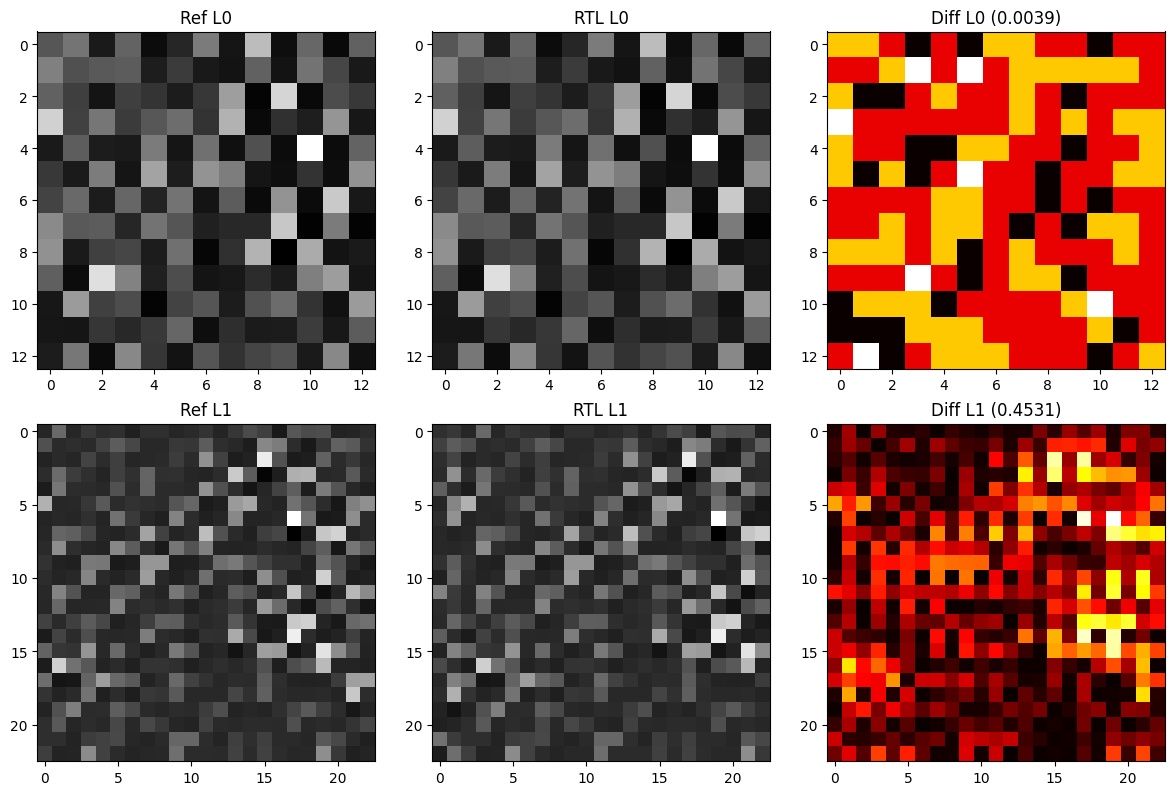

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import os

SCALE = 2 ** 10
BASE_DIR = "data/generator_test"

# Paths
REF_L0 = os.path.join(BASE_DIR, "ref_layer0.csv")
RTL_L0 = os.path.join(BASE_DIR, "rtl_layer0.csv")
REF_L1 = os.path.join(BASE_DIR, "ref_layer1.csv")
RTL_L1 = os.path.join(BASE_DIR, "rtl_layer1.csv")

def load_data(path, shape):
    try:
        data = np.loadtxt(path, dtype=int)
        expected = shape[0] * shape[1]
        if data.size != expected:
            # Pad or Crop biar script gak crash, tapi print warning
            if data.size < expected:
                data = np.pad(data, (0, expected - data.size))
            else:
                data = data[:expected]
        return data.reshape(shape) / SCALE
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return np.zeros(shape)

print("Verifying Slow Mode...")

# Layer 0
ref0 = load_data(REF_L0, (13, 13))
rtl0 = load_data(RTL_L0, (13, 13))
err0 = np.max(np.abs(ref0 - rtl0))
print(f"Layer 0 Max Error: {err0:.6f}")

# Layer 1
ref1 = load_data(REF_L1, (23, 23))
rtl1 = load_data(RTL_L1, (23, 23))
err1 = np.max(np.abs(ref1 - rtl1))
print(f"Layer 1 Max Error: {err1:.6f}")

# Plotting
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# L0
ax[0,0].imshow(ref0, cmap='gray'); ax[0,0].set_title("Ref L0")
ax[0,1].imshow(rtl0, cmap='gray'); ax[0,1].set_title("RTL L0")
ax[0,2].imshow(np.abs(ref0-rtl0), cmap='hot'); ax[0,2].set_title(f"Diff L0 ({err0:.4f})")

# L1
ax[1,0].imshow(ref1, cmap='gray'); ax[1,0].set_title("Ref L1")
ax[1,1].imshow(rtl1, cmap='gray'); ax[1,1].set_title("RTL L1")
ax[1,2].imshow(np.abs(ref1-rtl1), cmap='hot'); ax[1,2].set_title(f"Diff L1 ({err1:.4f})")

plt.tight_layout()
plt.show()